In [1]:
import numpy as np
import pandas as pd
import re
import os
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Dense, PReLU
from keras.optimizers import Adam
from KerasOutputCallBack import KerasOutputCallBack as KOCB

Using TensorFlow backend.


In [2]:
csv_data = pd.read_csv(os.path.join('data', 'hots_training_data.csv'), dtype=np.float32)

In [3]:
unplayed_maps = list()
for m in list(filter(lambda c: re.match("^map_",c) ,csv_data.columns)):
    if np.sum(csv_data[m]) == 0:
        unplayed_maps.append(m)
print("Unplayed map columns:", unplayed_maps)
unplayed_heroes = list()
for m in list(filter(lambda c: re.match("^[ab]_hero",c) ,csv_data.columns)):
    if np.sum(csv_data[m]) == 0:
        unplayed_heroes.append(m)
print("Unplayed hero columns:", unplayed_heroes)
csv_data = csv_data.drop(unplayed_maps + unplayed_heroes ,1)

Unplayed map columns: ['map_LostCavern', 'map_SilverCity', 'map_BraxisOutpost', 'map_Hanamura', 'map_CheckpointHanamura', 'map_PullParty', 'map_VolskayaFoundry', 'map_IndustrialDistrict']
Unplayed hero columns: ['a_herommr_Ana', 'a_herolevel_Ana', 'a_herommr_Junkrat', 'a_herolevel_Junkrat', 'b_herommr_Ana', 'b_herolevel_Ana', 'b_herommr_Junkrat', 'b_herolevel_Junkrat']


In [4]:
training_data, validation_data = train_test_split(csv_data, test_size=100000)
training_data.index = np.arange(0, training_data.shape[0])
validation_data.index = np.arange(0, validation_data.shape[0])

In [5]:
def split_features(data):
    labels = data['team_a_won'].astype(bool)
    features = data.drop(['team_a_won'],1)
    return features, labels

In [6]:
features, labels = split_features(training_data)

In [8]:
def hotsnet_init(input_dim, n=1000, d=.5, lr=.00005, beta_1=.7):
    model = Sequential()
    model.add(Dense(n, input_dim=input_dim, activation='linear'))
    model.add(PReLU())
    model.add(Dropout(d))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr, beta_1=beta_1), metrics=['accuracy'])
    return model

MODEL_FOLDER = 'saved_models'

def hotsnet_model(
    data, 
    target,
    test_size=100000,
    epochs=100, splits=6, 
    model_init=hotsnet_init,
    model_file='hotsnet',
    batch_size=2000
):  
    accs = []
    losses = []
    histories = []
    ss = ShuffleSplit(n_splits=splits, test_size=test_size)
    for i, (train, test) in enumerate(ss.split(data, target)):
        print('{} - Split {}/{}'.format(model_file, i+1, splits))
        filename = os.path.join(MODEL_FOLDER, "{}-{}.hdf5".format(model_file, i+1))
        model = model_init(data.shape[1])
        history = model.fit(
            data.loc[train].values, target.loc[train], 
            validation_data=(data.loc[test].values, target.loc[test]),
            epochs=epochs, batch_size=batch_size, 
            callbacks=[
                ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True),
                KOCB(skip_epochs=2),
                EarlyStopping(monitor='val_loss', min_delta=.000002, patience=4, verbose=0)
            ], verbose=0)
        histories.append(history)
        
        model.load_weights(filename)
        score = model.evaluate(data.loc[test].values, target[test], verbose=0)
        losses.append(score[0])
        accs.append(100*score[1])
        print("Test loss: {:.5f}; acc: {:.3f}%".format(score[0], 100*score[1]))
    with open(os.path.join(MODEL_FOLDER, "{}.json".format(model_file)), 'w') as f:
        f.write(model.to_json())
    print("Model accuracy: {:.2f}% +/- {:.2f}%".format(np.mean(accs), np.std(accs)))
    print("Model test_loss: {:.5f} +/- {:.5f}".format(np.mean(losses), np.std(losses)))
    return histories

In [9]:
histories = hotsnet_model(features, labels)

hotsnet - Split 1/6
Epoch 1(22s) - train_loss: 0.67824; train_acc: 56.621%; val_loss: 0.66976; val_acc: 58.510%
Epoch 4(16s) - train_loss: 0.66432; train_acc: 59.460%; val_loss: 0.66157; val_acc: 59.781%
Epoch 7(16s) - train_loss: 0.65788; train_acc: 60.529%; val_loss: 0.65624; val_acc: 60.705%
Epoch 10(16s) - train_loss: 0.65368; train_acc: 61.153%; val_loss: 0.65312; val_acc: 61.290%
Epoch 13(16s) - train_loss: 0.65085; train_acc: 61.501%; val_loss: 0.65109; val_acc: 61.584%
Epoch 16(16s) - train_loss: 0.64872; train_acc: 61.813%; val_loss: 0.64977; val_acc: 61.738%
Epoch 19(16s) - train_loss: 0.64700; train_acc: 61.992%; val_loss: 0.64872; val_acc: 61.830%
Epoch 22(16s) - train_loss: 0.64576; train_acc: 62.182%; val_loss: 0.64812; val_acc: 61.895%
Epoch 25(17s) - train_loss: 0.64452; train_acc: 62.384%; val_loss: 0.64763; val_acc: 61.925%
Epoch 28(17s) - train_loss: 0.64352; train_acc: 62.519%; val_loss: 0.64736; val_acc: 61.946%
Epoch 31(17s) - train_loss: 0.64269; train_acc: 62.61

Epoch 10(16s) - train_loss: 0.65397; train_acc: 61.080%; val_loss: 0.65168; val_acc: 61.385%
Epoch 13(16s) - train_loss: 0.65102; train_acc: 61.509%; val_loss: 0.64955; val_acc: 61.640%
Epoch 16(16s) - train_loss: 0.64898; train_acc: 61.776%; val_loss: 0.64813; val_acc: 61.793%
Epoch 19(16s) - train_loss: 0.64717; train_acc: 62.003%; val_loss: 0.64727; val_acc: 61.945%
Epoch 22(16s) - train_loss: 0.64575; train_acc: 62.200%; val_loss: 0.64666; val_acc: 61.979%
Epoch 25(17s) - train_loss: 0.64474; train_acc: 62.372%; val_loss: 0.64613; val_acc: 62.095%
Epoch 28(17s) - train_loss: 0.64377; train_acc: 62.464%; val_loss: 0.64584; val_acc: 62.112%
Epoch 31(17s) - train_loss: 0.64288; train_acc: 62.577%; val_loss: 0.64565; val_acc: 62.144%
Epoch 34(17s) - train_loss: 0.64221; train_acc: 62.656%; val_loss: 0.64553; val_acc: 62.180%
Epoch 37(16s) - train_loss: 0.64131; train_acc: 62.776%; val_loss: 0.64536; val_acc: 62.225%
Epoch 40(17s) - train_loss: 0.64078; train_acc: 62.851%; val_loss: 0.6

In [11]:
for history in histories:
    h = zip(
        history.history['acc'], 
        history.history['loss'],
        history.history['val_loss'],
        history.history['val_acc'])
    best_epoch = list(filter(lambda x: np.min(history.history['val_loss']) > x[2] - .000000001, h))
    print(best_epoch)

[(0.63173143740425097, 0.63823874058299224, 0.64649855256080624, 0.62066003203392028)]
[(0.63103098546816283, 0.6389610506309884, 0.64794273734092711, 0.61990003705024721)]
[(0.63277148462446198, 0.6376563058143303, 0.64628062248229978, 0.62124004483222961)]
[(0.63438826614055155, 0.63638471507725669, 0.64610848307609559, 0.62057003617286677)]
[(0.6302171171338079, 0.63958375081323493, 0.64511847853660587, 0.62238004684448245)]
[(0.63073649939921317, 0.63883428434654022, 0.64556138515472417, 0.6214100468158722)]


In [72]:
BUCKETS=21
probs = np.arange(0,1.001,1/BUCKETS)

np.seterr(divide='ignore', invalid='ignore')

def test_calibration(preds, targets):
    correct = np.zeros(BUCKETS+1)
    total = np.zeros(BUCKETS+1)
    for (pred, target) in zip(preds, targets):
        c_bucket = int(round(pred[0]*BUCKETS))
        total[c_bucket] = total[c_bucket] + 1
        if target:
            correct[c_bucket] = correct[c_bucket] + 1
    percent = correct / total
    
    bucket_distribution = total / len(targets)
    distribution = [np.sum(bucket_distribution[0:i+1]) for i in range(0, len(bucket_distribution))]
    plt.figure(figsize=(4,3))
    
    plt.xlabel('Predicted chance of winning')
    plt.plot(probs, percent, label="Chance team won")
    plt.plot(probs, distribution, label="Percent of predictions")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

Overall - 100000 samples in validation data


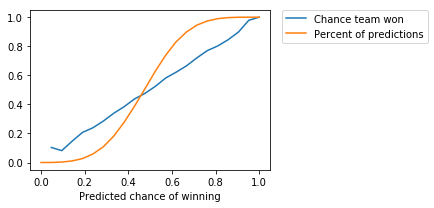

mode_QuickMatch - 65436 samples in validation data


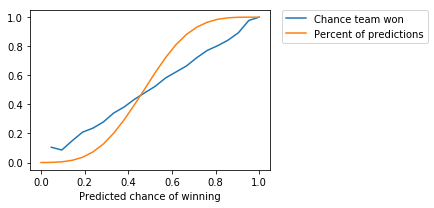

mode_HeroLeague - 18689 samples in validation data


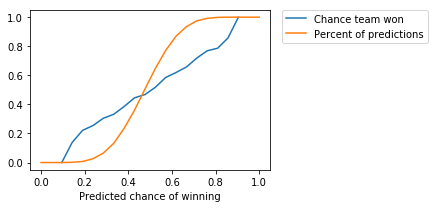

mode_TeamLeague - 7914 samples in validation data


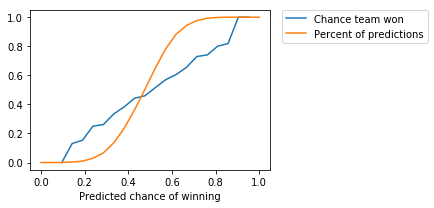

mode_UnrankedDraft - 7961 samples in validation data


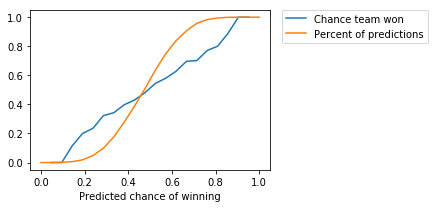

In [67]:
model = hotsnet_init(features.shape[1])
val_features, val_labels = split_features(validation_data)
print("{} - {} samples in validation data".format('Overall', val_features.shape[0]))
model = hotsnet_init(val_features.shape[1])
model.load_weights(os.path.join(MODEL_FOLDER, 'hotsnet-5.hdf5'))
test_calibration(model.predict(val_features.values), val_labels)

for gamemode in filter(lambda c: re.match("^mode_",c), csv_data.columns):
    val_features, val_labels = split_features(validation_data[validation_data[gamemode] == 1])
    print("{} - {} samples in validation data".format(gamemode, val_features.shape[0]))
    test_calibration(model.predict(val_features.values), val_labels)

In [59]:
preds = model.predict(val_features.values)

def confidence(x):
    c = 0
    for p in preds:
        if p > x or 1 - p > x:
            c += 1
    return c / len(preds)

In [64]:
for i in np.arange(.5,1.001,.05):
    print('{}\% & {:.2f}\% \\'.format(int(100*i), 100*confidence(i)))

50\% & 100.00\% \
55\% & 74.72\% \
60\% & 51.82\% \
65\% & 32.63\% \
70\% & 18.78\% \
75\% & 9.54\% \
80\% & 4.11\% \
85\% & 1.42\% \
90\% & 0.35\% \
95\% & 0.04\% \
100\% & 0.00\% \


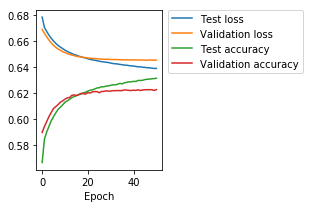

In [177]:
plt.figure(figsize=(2.5,3))
plt.xlabel('Epoch')
i=4
plt.plot(histories[i].history['loss'], label='Test loss')
plt.plot(histories[i].history['val_loss'], label='Validation loss')
plt.plot(histories[i].history['acc'], label='Test accuracy')
plt.plot(histories[i].history['val_acc'], label='Validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()
    
    

In [45]:
for i, k in enumerate(histories[5].history['val_loss']):
    if k == np.min(histories[5].history['val_loss']):
        print(i)

49


In [44]:
validation_data.to_csv('validation.csv')

In [54]:
for gamemode in filter(lambda c: re.match("^mode_",c), csv_data.columns):
    val_features, val_labels = split_features(validation_data[validation_data[gamemode] == 1])
    score = model.evaluate(val_features.values, val_labels, verbose=0)
    print("{} - {:.2f}% of {} samples predicted".format(gamemode, 100*score[1], val_features.shape[0]))

mode_QuickMatch - 63.04% of 65436 samples predicted
mode_HeroLeague - 59.99% of 18689 samples predicted
mode_TeamLeague - 59.87% of 7914 samples predicted
mode_UnrankedDraft - 61.81% of 7961 samples predicted


In [76]:
def benchmark_model(data, target, splits=4, test_size=100000):
    scores = []
    ss = ShuffleSplit(n_splits=splits, test_size=test_size)
    for train, test in tqdm(ss.split(data, target), total=splits, unit='splits'):
        gnb = GaussianNB()
        y_pred = gnb.fit(data.loc[train], target.loc[train]).predict(data.loc[test])
        acc = 100 * float((target.loc[test] == y_pred).sum()) / len(test)
        scores.append(acc)
    print("Benchmark accuracy: {:.2f}% +/- {:.2f}%".format(np.mean(scores), np.std(scores)))
    return scores


features, labels = split_features(training_data)

benchmark_model(features, labels);

100%|██████████| 4/4 [00:59<00:00, 15.36s/splits]

Benchmark accuracy: 56.70% +/- 0.14%


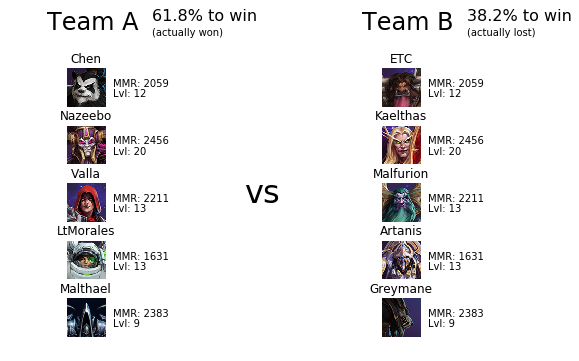

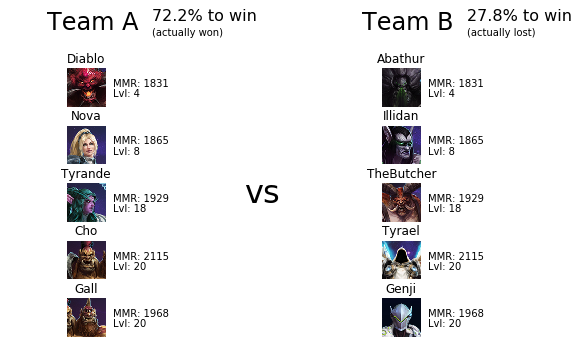

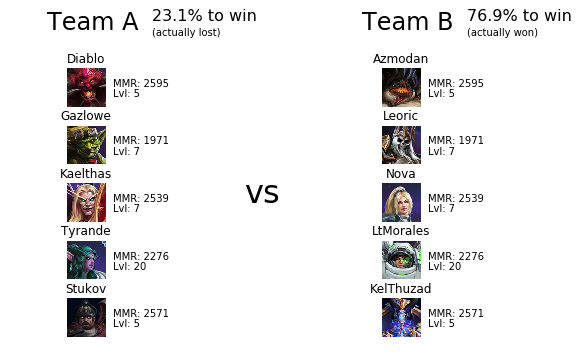

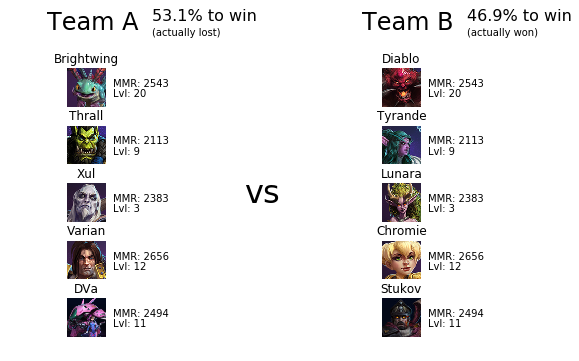

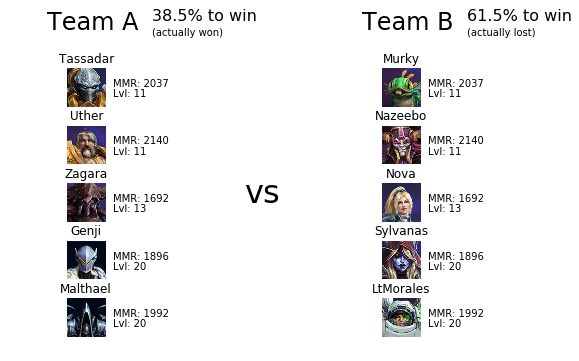

In [282]:
herolevels = list(filter(lambda c: re.match("^[ab]_herolevel",c), csv_data.columns))
herommrs = list(filter(lambda c: re.match("^[ab]_herommr",c), csv_data.columns))
def make_human(row):
    teama = {}
    teamb = {}
    for h in herolevels:
        if row[h] != 0:
            hero = h.split('_')[2]
            level =int(round(row[h] * 25) - 5)
            if h[0] is 'a':
                teama.setdefault(hero, {})['level'] = level
            else:
                teamb.setdefault(hero, {})['level'] = level
    for h in herommrs:
        if row[h] != 0:
            hero = h.split('_')[2]
            mmr = int(round(row[h] * 4500))
            if h[0] is 'a':
                teama.setdefault(hero, {})['mmr'] = mmr
            else:
                teamb.setdefault(hero, {})['mmr'] = mmr
    return (teama, teamb)

def print_game_text(teama, teamb, teama_won):
    print("        Team A{:5}                      Team B{:5}".format(
        '(won)' if teama_won else '', '(won)' if not teama_won else ''))
    print("Hero           MMR  Lvl          Hero           MMR  Lvl")
    for i, (a,b) in enumerate(zip(teama, teamb)):
        print("{:12} {:>6}  {:>2}    {:2}    {:12} {:>6}  {:>2}".format(
            a, teama[a]['mmr'], teama[a]['level'],
            'vs' if i is 2 else ' ',
            b, teamb[b]['mmr'], teamb[b]['level']))
    if prediction > .5: 
        pwinner = 'A'
        prob = prediction
    else:
        pwinner = 'B'
        prob = 1 - prediction
    print("Team {} is expected to win {:.1f}% of the time.".format(pwinner, 100*prob))
 
        

def print_game(teama, teamb, teama_won, prediction): 
    plt.figure(1, figsize=(8, 6))
    ax = plt.subplot(6, 3, 1)
    ax.axis('off', label=str(1))
    ax.text(.2,.5,"Team A", size=24)
    ax.text(1,.75,'{:.1f}% to win'.format(prediction*100), size=16)
    ax.text(1,.35,'(actually {})'.format('won' if teama_won else 'lost'))
    
    ax = plt.subplot(6, 3, 3)
    ax.axis('off', label=str(3))
    ax.text(.2,.5,"Team B", size=24)
    ax.text(1,.75,'{:.1f}% to win'.format((1-prediction)*100), size=16)
    ax.text(1,.35,'(actually {})'.format('won' if not teama_won else 'lost'))
    
    ax = plt.subplot(6, 3, 3*2+5)
    ax.axis('off', label=str(3*2+5))
    ax.text(.5,.5,"vs", size=32)
    for i, (a,b) in enumerate(zip(teama, teamb)):
        ax = plt.subplot(6, 3, i*3+4)
        ax.axis('off', label=str(i*3+4))
        plt.title(a)
        img = plt.imread(os.path.join('portraits', '{}.png'.format(a)))
        ax.imshow(img)
        ax.text(90,35, "MMR: {}".format(teama[a]['mmr']))
        ax.text(90,55, "Lvl: {}".format(teama[a]['level']))
        ax = plt.subplot(6, 3, i*3+6)
        ax.axis('off', label=str(i*3+6))
        plt.title(b)
        img = plt.imread(os.path.join('portraits', '{}.png'.format(b)))
        ax.imshow(img)
        ax.text(90,35, "MMR: {}".format(teama[a]['mmr']))
        ax.text(90,55, "Lvl: {}".format(teama[a]['level']))
    plt.subplots_adjust(hspace=.5)
    plt.show()
        
val_features, val_labels = split_features(validation_data.sample(5))
for i, row in val_features.iterrows():
    if i > 0:
        print("\n\n")
    teama, teamb = make_human(row)
    prediction = model.predict(row.values.reshape(1,338))[0][0]    
    print_game(teama, teamb, val_labels[i], prediction)